In [ ]:
# ! pip install seaborn

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from sklearn.cluster import KMeans

%matplotlib inline

In [53]:
def PlotExplainedVariancePlot(explainedVarianceRatio, cumumlativeExplainedVarianceRatio):
    plt.bar(range(0,len(explainedVarianceRatio)), explainedVarianceRatio, alpha=0.5, align='center', label='Individual explained variance ratio')
    plt.step(range(0,len(cumumlativeExplainedVarianceRatio)), cumumlativeExplainedVarianceRatio, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def ApplyPCA(X, NoOfPCs=None):
    scaler = StandardScaler()
    sc = StandardScaler()
    sc.fit(X)
    XScaled = sc.transform(X)
    if (NoOfPCs==None):
        pca = PCA().fit(XScaled)
        xPCA = PCA().fit_transform(X)
    else:
        pca = PCA(n_components=NoOfPCs).fit(XScaled)
        xPCA = PCA(n_components=NoOfPCs).fit_transform(X)
   
           
    # Get cumulative explained variance for each dimension
    pcaExplainedVariance = pca.explained_variance_
    pcaExplainedVarianceRatio = pca.explained_variance_ratio_
    cumumlativeExplainedVarianceRatio = np.cumsum(pcaExplainedVarianceRatio)
    noOfComponents = len(pcaExplainedVariance)
    # Get dimensions where var >= 85% 
    noOfDesiredComponents = np.argmax(cumumlativeExplainedVarianceRatio >= 0.80) + 1
    
    print(f"We can reduce from {noOfComponents} to {noOfDesiredComponents} dimensions while retaining 80% of variance.")    
        
    return pca, xPCA, pcaExplainedVariance, pcaExplainedVarianceRatio, cumumlativeExplainedVarianceRatio


def PCAFeatureCorrelation(X, xPCA, pcaExplainedVarianceRatio, features):

    # Get correlation between original features (X) and PCs (xPCA)
    dotMatrix = np.dot(X.T, xPCA)
    print(dotMatrix.shape)
    # Form a dataframe of correlation matrix with columns representing PCs and rows representing features
    dfDotMat = pd.DataFrame(dotMatrix)
    dfDotMat.columns = [''.join(['PC', f'{i+1}']) for i in range(dotMatrix.shape[1])]
    if any(features): dfDotMat.index = features    

    # Normalize & Sort
    dfDotMatNormalizedAbsolute, dfDotMatNormalizedAbsoluteByVar = NormalizeCorrelatedMatrix(dfDotMat, pcaExplainedVarianceRatio)
    
    return dfDotMatNormalizedAbsolute, dfDotMatNormalizedAbsoluteByVar


def NormalizeCorrelatedMatrix(dfDotMat, pcaExplainedVarianceRatio):

    # Normalize and Sort in descending order
    dfDotMatNormalized = (dfDotMat.copy()-dfDotMat.mean())/dfDotMat.std()
    dfDotMatNormalized = dfDotMatNormalized.sort_values(list(dfDotMatNormalized.columns), ascending=False)
    # Reorder in descending order after taking absolute
    dfDotMatNormalizedAbsolute = dfDotMatNormalized.copy().abs().set_index(dfDotMatNormalized.index)
    dfDotMatNormalizedAbsolute = dfDotMatNormalizedAbsolute.sort_values(by=list(dfDotMatNormalizedAbsolute.columns), ascending=False)   

    # Re-normalize by multiplying it with explained variance ratio and sort in descending order
    dfDotMatNormalizedAbsoluteByVar = dfDotMatNormalizedAbsolute.copy()*pcaExplainedVarianceRatio
    dfDotMatNormalizedAbsoluteByVar = dfDotMatNormalizedAbsoluteByVar.sort_values(by=list(dfDotMatNormalized.columns), ascending=False)
    ax_relative = sns.heatmap(dfDotMatNormalizedAbsoluteByVar, cmap="Purples")
    ax_relative.set_title("|Normalized|*Explained_Variance")

    return dfDotMatNormalizedAbsolute, dfDotMatNormalizedAbsoluteByVar


def RankFeaturesPCA(dfDotMatNormalizedAbsoluteByVar):
    # dfDotMatNormalizedAbsoluteByVar is a dataframe with shape (no of features, no of PCAs)
    # dfDotMatNormalizedAbsoluteByVar is also normalized and multiplied with explained variance ratio
    # Ranking is done based on summing each row and sorting in descending order
    dfRank = dfDotMatNormalizedAbsoluteByVar.copy().assign(score = dfDotMatNormalizedAbsoluteByVar.sum(axis=1)).sort_values('score', ascending=False)
    dfRank['feature'] = dfRank.index
    dfRank.index = range(1, len(dfRank)+1)
    dfRank.drop(dfDotMatNormalizedAbsoluteByVar.columns, axis=1, inplace=True)
    dfRank.index.rename('rank', inplace=True)
    return dfRank

def GeneratePCAReport(X, features, noOfPCs=None):
    # Retrieve the interactive report
    pca, xPCA, pcaExplainedVariance, pcaExplainedVarianceRatio, cumumlativeExplainedVarianceRatio = ApplyPCA(X, noOfPCs)
    # Plot Explained Variance Graph
    PlotExplainedVariancePlot(pcaExplainedVarianceRatio, cumumlativeExplainedVarianceRatio)
    # Get feature-PC correlation matrices
    dfDotMatNormalizedAbsolute, dfDotMatNormalizedAbsoluteByVar = PCAFeatureCorrelation(X, xPCA, pcaExplainedVarianceRatio, features) 
    # Get rank for each feature
    dfRank = RankFeaturesPCA(dfDotMatNormalizedAbsoluteByVar)
    return (pca, xPCA, pcaExplainedVariance, pcaExplainedVarianceRatio, dfDotMatNormalizedAbsolute, dfDotMatNormalizedAbsoluteByVar, dfRank)

## Run PCA without specifying number of components

We can reduce from 8 to 5 dimensions while retaining 80% of variance.


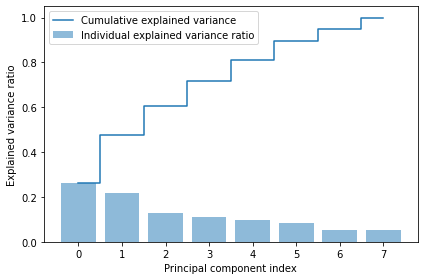

(8, 8)
Number of components PCA generated: 8
----------------Explained variance for each component----------------
[2.09711056 1.73346726 1.03097228 0.87667054 0.76333832 0.68351839
 0.42036353 0.40498938]
----------------Explained variance ratio for each component----------------
[0.26179749 0.21640127 0.12870373 0.10944113 0.09529305 0.08532855
 0.05247702 0.05055776]
----------------Feature Weights for each component----------------
[[0.1284321  0.39308257 0.36000261 0.43982428 0.43502617 0.45194134
  0.27061144 0.19802707]
 [0.59378583 0.17402908 0.18389207 0.33196534 0.25078106 0.1009598
  0.122069   0.62058853]
 [0.01308692 0.46792282 0.53549442 0.2376738  0.33670893 0.36186463
  0.43318905 0.07524755]
 [0.08069115 0.40432871 0.05598649 0.03797608 0.34994376 0.05364595
  0.8336801  0.0712006 ]
 [0.47560573 0.46632804 0.32795306 0.48786206 0.34693481 0.25320376
  0.11981049 0.10928996]
 [0.19359817 0.09416176 0.6341159  0.00958944 0.27065061 0.68537218
  0.08578409 0.03335717]
 [0

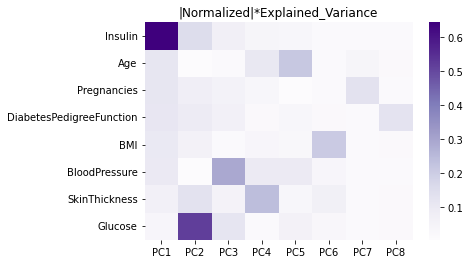

In [55]:
df = pd.read_csv('diabetes.csv')
train_X = df[[x for x in df.columns if x not in ["Outcome"]]]
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
diabetes_outputs = GeneratePCAReport(X=train_X.values, features=feature_names)
print("Number of components PCA generated: " + str(len(diabetes_outputs[2])))
print("----------------Explained variance for each component----------------")
print(diabetes_outputs[2])
print("----------------Explained variance ratio for each component----------------")
print(diabetes_outputs[3])
print("----------------Feature Weights for each component----------------")
print(abs(diabetes_outputs[0].components_))
print("----------------Normalized Feature Weights for each component----------------")
print(diabetes_outputs[5])
print("----------------Rank of each feautre----------------")
print(diabetes_outputs[-1])

## Run PCA for specific components and specific features

We can reduce from 5 to 4 dimensions while retaining 80% of variance.


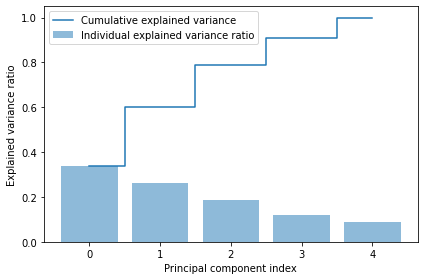

(5, 5)
Number of components PCA generated: 5
----------------Explained variance for each component----------------
[1.6951386  1.31263711 0.94371281 0.6029669  0.45206349]
----------------Explained variance ratio for each component----------------
[0.33858628 0.26218559 0.1884968  0.12043636 0.09029497]
----------------Feature Weights for each component----------------
[[0.4809046  0.39654553 0.48779528 0.57588323 0.20468677]
 [0.31173133 0.29633575 0.46024533 0.32520534 0.70528322]
 [0.55603948 0.70631302 0.31930232 0.29935652 0.01933151]
 [0.41603956 0.46710042 0.37340337 0.11259779 0.67573659]
 [0.43506956 0.19461724 0.5557391  0.67845958 0.06070628]]
----------------Normalized Feature Weights for each component----------------
                    PC1       PC2       PC3       PC4       PC5
Insulin        0.603096  0.188699  0.116483  0.038608  0.034720
Age            0.187508  0.048015  0.048864  0.094918  0.149286
BloodPressure  0.171947  0.048679  0.311685  0.078224  0.078746
Ski

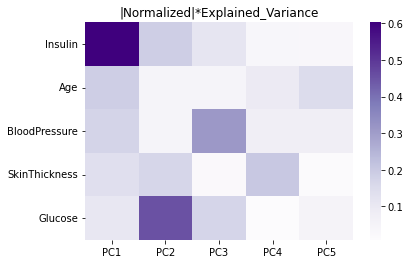

In [56]:
feature_names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']
train_X = df[[x for x in df.columns if x not in ['Outcome', 'DiabetesPedigreeFunction', 'BMI', 'Pregnancies']]]
diabetes_outputs = GeneratePCAReport(X=train_X.values, features=feature_names, noOfPCs=5)
print("Number of components PCA generated: " + str(len(diabetes_outputs[2])))
print("----------------Explained variance for each component----------------")
print(diabetes_outputs[2])
print("----------------Explained variance ratio for each component----------------")
print(diabetes_outputs[3])
print("----------------Feature Weights for each component----------------")
print(abs(diabetes_outputs[0].components_))
print("----------------Normalized Feature Weights for each component----------------")
print(diabetes_outputs[5])
print("----------------Rank of each feautre----------------")
print(diabetes_outputs[-1])